In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
import scipy
import statistics

# Import Raw Data

In [2]:
df0=pd.read_csv('Supplementary_Table5_CoV_Curated_RawData.csv')

# Data processing

In [3]:
# Inputting not-measured interactions to lowest value in the set
df0.pred_aff=df0.pred_aff.fillna(np.max(df0.pred_aff))

df0['interaction'] = df0.mata_description + '$' + df0.matalpha_description 

df=df0.pivot(index='interaction', columns='sample_name', values='pred_aff').reset_index()
df[['mata','matalpha']] = df.interaction.str.split(expand=True,pat='$') 

df['aff_mean']= df[[1,2,3]].mean(axis=1)
df['aff_std']= df[[1,2,3]].std(axis=1)
df['aff_cv']= np.abs(df.aff_std / df.aff_mean)

df['aff_1_nm']= np.exp(df[1])
df['aff_2_nm']= np.exp(df[2])
df['aff_3_nm']= np.exp(df[3])

df['aff_mean_nm']= df[['aff_1_nm','aff_2_nm','aff_3_nm']].mean(axis=1)
df['aff_std_nm']= df[['aff_1_nm','aff_2_nm','aff_3_nm']].std(axis=1)
df['aff_cv_nm']= np.abs(df.aff_std_nm / df.aff_mean_nm) *100

df=df.sort_values(by='aff_mean')

# Merging dataframe with antibody full names

In [4]:
names = pd.read_csv('Supplementary_Table6_AntibodiesNameFormats.csv')
names['Short_Name']=names.Short_Name + '_HL'

names2 = pd.read_csv('Supplementary_Table6_AntibodiesNameFormats.csv')
names2['Short_Name']=names2.Short_Name + '_LH'

names3 = pd.read_csv('Supplementary_Table6_AntibodiesNameFormats.csv')
names3['Short_Name']=names3.Short_Name

names4 = pd.concat([names,names2,names3])
names4.append(pd.DataFrame([['ACE2','ACE2']], columns=['Name','Short_Name']))

df=pd.merge(df,names4,left_on='mata',right_on='Short_Name',how='outer').reset_index(drop=True)
df=df.dropna(subset=['mata'])

df['LH']=df.mata.str.contains('_LH').replace({True: '_LH', False: ''})
df['HL']=df.mata.str.contains('_HL').replace({True: '_HL', False: ''})
df['Name2']=df.Name + df.LH + df.HL

# Filtering for best chain orientation

In [14]:
#Selecting the best chain orientation for each antibody
df4=df[df.matalpha == 'SARS-CoV2 WT CODON 1']
df4=df4[df4.mata.str.contains("CoV")]
df4=df4.sort_values(by='Name').reset_index(drop=True)
df4=df4.loc[df4.reset_index().groupby(['Name'])['aff_mean'].idxmin()]
best_mata=df4.mata
df5=df[df.mata.str.contains("|".join(best_mata))]



df5['binderno']=pd.to_numeric(df5.mata.str.extract(r'(?:binder_)(\d+)').iloc[:,0])
df5=df5.sort_values(by='binderno').reset_index(drop=True)
df5

#df5 contains subset of data with best orientation binder to RBD

interaction         1         2  \
0                 CoV_binder_1_LH$SARS-CoV2 V367F  1.816275  1.688621   
1     CoV_binder_1_LH$SARS-CoV2 N501Y+K417T+E484K  3.893253  2.743772   
2                 CoV_binder_1_LH$SARS-CoV2 E406W  4.215304  2.353880   
3                 CoV_binder_1_LH$SARS-CoV2 E484Q  2.946195  2.250238   
4                 CoV_binder_1_LH$SARS-CoV2 G446V  2.416901  4.811204   
...                                           ...       ...       ...   
1744                CoV_binder_33$SARS-CoV2 E484Q  3.640991  1.893409   
1745                         CoV_binder_33$RaTG13  3.491744  1.698401   
1746                CoV_binder_33$SARS-CoV2 A475V  3.771057  3.833508   
1747                CoV_binder_33$SARS-CoV2 N501S  1.971356  3.952976   
1748                CoV_binder_33$SARS-CoV2 V483A  2.406353  1.787774   

             3             mata                     matalpha  aff_mean  \
0     1.724094  CoV_binder_1_LH              SARS-CoV2 V367F  1.742997   
1     1.927897  CoV_binder_1_LH  SARS-CoV2 N501Y+K417T+E484K  2.854974   
2     2.119027  CoV_binder_1_LH              SARS-CoV2 E406W  2.896070   
3     3.869528  CoV_binder_1_LH              SARS-CoV2 E484Q  3.021987   
4     1.911689  CoV_binder_1_LH              SARS-CoV2 G446V  3.046598   
...        ...              ...                          ...       ...   
1744  3.150439    CoV_binder_33              SARS-CoV2 E484Q  2.894947   
1745  3.592821    CoV_binder_33                       RaTG13  2.927656   
1746  1.294697    CoV_binder_33              SARS-CoV2 A475V  2.966421   
1747  3.121937    CoV_binder_33              SARS-CoV2 N501S  3.015423   
1748  2.949520    CoV_binder_33              SARS-CoV2 V483A  2.381216   

       aff_std    aff_cv   aff_1_nm  ...  aff_mean_nm  aff_std_nm   aff_cv_nm  \
0     0.065892  0.037804   6.148908  ...     5.722787    0.381749    6.670676   
1     0.987386  0.345847  49.070262  ...    23.830271   22.284235   93.512300   
2     1.148508  0.396575  67.714714  ...    28.854693   33.671792  116.694333   
3     0.812301  0.268797  19.033387  ...    25.481046   20.009774   78.528071   
4     1.548931  0.508413  11.211058  ...    46.951679   65.792978  140.129126   
...        ...       ...        ...  ...          ...         ...         ...   
1744  0.901370  0.311360  38.129598  ...    22.705965   15.753576   69.380780   
1745  1.065765  0.364033  32.843192  ...    24.881614   16.905576   67.944052   
1746  1.448092  0.488161  43.425934  ...    31.100078   23.813703   76.571198   
1747  0.995095  0.330002   7.180408  ...    27.320285   22.810061   83.491301   
1748  0.581281  0.244111  11.093428  ...    12.055451    6.613018   54.855005   

           Short_Name         Name               Name_extra   LH HL  \
0     CoV_binder_1_LH  Casirivimab  Casirivimab / REGN10933  _LH      
1     CoV_binder_1_LH  Casirivimab  Casirivimab / REGN10933  _LH      
2     CoV_binder_1_LH  Casirivimab  Casirivimab / REGN10933  _LH      
3     CoV_binder_1_LH  Casirivimab  Casirivimab / REGN10933  _LH      
4     CoV_binder_1_LH  Casirivimab  Casirivimab / REGN10933  _LH      
...               ...          ...                      ...  ... ..   
1744    CoV_binder_33       VHH-55                   VHH-55           
1745    CoV_binder_33       VHH-55                   VHH-55           
1746    CoV_binder_33       VHH-55                   VHH-55           
1747    CoV_binder_33       VHH-55                   VHH-55           
1748    CoV_binder_33       VHH-55                   VHH-55           

               Name2 binderno  
0     Casirivimab_LH        1  
1     Casirivimab_LH        1  
2     Casirivimab_LH        1  
3     Casirivimab_LH        1  
4     Casirivimab_LH        1  
...              ...      ...  
1744          VHH-55       33  
1745          VHH-55       33  
1746          VHH-55       33  
1747          VHH-55       33  
1748          VHH-55       33  

[1749 rows x 22 columns]

In [12]:
# # # # Added code

#Import curated table with experimental data
exp_data = pd.read_csv('aalpha_bio_RBD_sequence_data_raw.csv')
exp_data = exp_data.iloc[: , 1:]
exp_data_list = exp_data.values.tolist()

#only look for the WT measurements ex. SARS-CoV2 WT
list_de = ['SARS-CoV2 WT CODON 1','SARS-CoV2 WT CODON 2','SARS-CoV2 WT CODON 3', 'SARS-CoV2 WT CODON 4', 'SARS-CoV2_RBD']
WT_data = df5.loc[df5['matalpha'].isin(list_de)]

WT_data_list = WT_data.values.tolist()

final_data = []
processed_val = []

#Here we find the mata or Short_Name to cluster the measurements
for n in exp_data_list:
    short_energies = []
    short_std = []
    for t in WT_data_list:
        if '_LH' in t[4] or  '_HL' in t[4]:
         name_seq = t[4][0:len(t[4])-3]
        else:
            name_seq = t[4]
        if n[0] == name_seq:
        #We extract antigen name(mataalpha), affinity predicted in nm (aff_mean_nm) and its std
            antigen_name = t[5]
            aff_mean_nm = t[6]
            aff_std_nm = t[7]
            short_energies.append(t[6])
            short_std.append(t[7])
            final_data.append([name_seq,antigen_name,aff_mean_nm,aff_std_nm])
    #calculated the mean and std across the different codons
    processed_val.append([n[0],*short_energies,*short_std, statistics.mean(short_energies),statistics.stdev(short_energies)])
    
prede_aalpha = pd.DataFrame(processed_val)
prede_aalpha.columns =['Short_Name','SARS-CoV2 WT affinty nM (1)','SARS-CoV2 WT affinty nM (2)', 'SARS-CoV2 WT affinty nM (3)', 'SARS-CoV2 WT affinty nM (4)', 'SARS-CoV2 WT std (1)','SARS-CoV2 WT std (2)', 'SARS-CoV2 WT std (3)', 'SARS-CoV2 WT std (4)', 'aalpha_pred_affinity_all_codons (nM)','aalpha_pred_std_all_codons' ]

aalpha_data_all = pd.concat([exp_data, prede_aalpha], axis=1, ignore_index=False)
aalpha_data_all.to_csv('aalpha_bio_RBD_sequence_data_processed.csv')
aalpha_data_all['affinity_RBD_nM_ln'] = np.log(aalpha_data_all['affinity_RBD_nM'])

aalpha_data_all


Short_Name                                 Name  \
0    CoV_binder_1              REGN10933 (casirivimab)   
1    CoV_binder_2                REGN10987 (imdevimab)   
2    CoV_binder_3  Bamlanivimab (LY3819253, LY-CoV555)   
3    CoV_binder_4                 Regdanvimab (CT-P59)   
4    CoV_binder_5     Sotrovimab (VIR-7831/GSK4182136)   
5    CoV_binder_6        AZD8895/Tixagevimab/COV2-2196   
6    CoV_binder_7                   AZD1061/Cilgavimab   
7    CoV_binder_8                     Etesevimab / CB6   
8    CoV_binder_9                  COR-101 / STE90-C11   
9   CoV_binder_10                               CC12.1   
10  CoV_binder_11                               Fab-52   
11  CoV_binder_12                                 BD23   
12  CoV_binder_13                             m396-B10   
13  CoV_binder_14                            CR3014-C8   
14  CoV_binder_15                            CR3014-D1   
15  CoV_binder_16                            CR3022-B6   
16  CoV_binder_17                           CR3022-B11   
17  CoV_binder_18                           CR3022-G11   
18  CoV_binder_19                                 FC05   
19  CoV_binder_20                                  P17   
20  CoV_binder_21                                 P4A1   
21  CoV_binder_22                               S2-E12   
22  CoV_binder_23                               S2-M11   
23  CoV_binder_24                               CR3022   
24  CoV_binder_25                                 m396   
25  CoV_binder_26                            REGN-3051   
26  CoV_binder_27                           REGN-3048    
27  CoV_binder_28                                 MR17   
28  CoV_binder_29                               VHH-72   
29  CoV_binder_30                                  Ty1   
30  CoV_binder_31                                 Nb#6   
31  CoV_binder_32                              VHH-21    
32  CoV_binder_33                               VHH-55   

                                          Institution Target    Phase Type  \
0                                           Regeneron  CoV-2  Phase 3  IGG   
1                                           Regeneron  CoV-2  Phase 3  IGG   
2                             AbCellera/Eli Lilly/NIH  CoV-2  Phase 3  IGG   
3                                           Celltrion  CoV-2  Phase 3  IGG   
4                               Vir biotechnology/GSK  CoV-2  Phase 3  IGG   
5   AstraZeneca/Vanderbilt University Medical Cent...  CoV-2  Phase 3  IGG   
6   AstraZeneca/Vanderbilt University Medical Cent...  CoV-2  Phase 3  IGG   
7   Junshi Biosciences/Institute of Microbiology, ...  CoV-2  Phase 2  IGG   
8                           YUMAB /CORAT therapeutics  CoV-2  Phase 2  IGG   
9                                                 NaN  CoV-2      NaN  IGG   
10                                                NaN  CoV-2      NaN  IGG   
11                                                NaN  CoV-2      NaN  IGG   
12                                                NaN  CoV-2      NaN  IGG   
13                                                NaN  CoV-2      NaN  IGG   
14                                                NaN  CoV-2      NaN  IGG   
15                                                NaN  CoV-2      NaN  IGG   
16                                                NaN  CoV-2      NaN  IGG   
17                                                NaN  CoV-2      NaN  IGG   
18                                                NaN  CoV-2      NaN  IGG   
19                                                NaN  CoV-2      NaN  IGG   
20                                                NaN  CoV-2      NaN  IGG   
21                                                NaN  CoV-2      NaN  IGG   
22                                                NaN  CoV-2      NaN  IGG   
23                                                NaN  CoV-1      NaN  IGG   
24                                                NaN  CoV-1      NaN  IGG   
25    

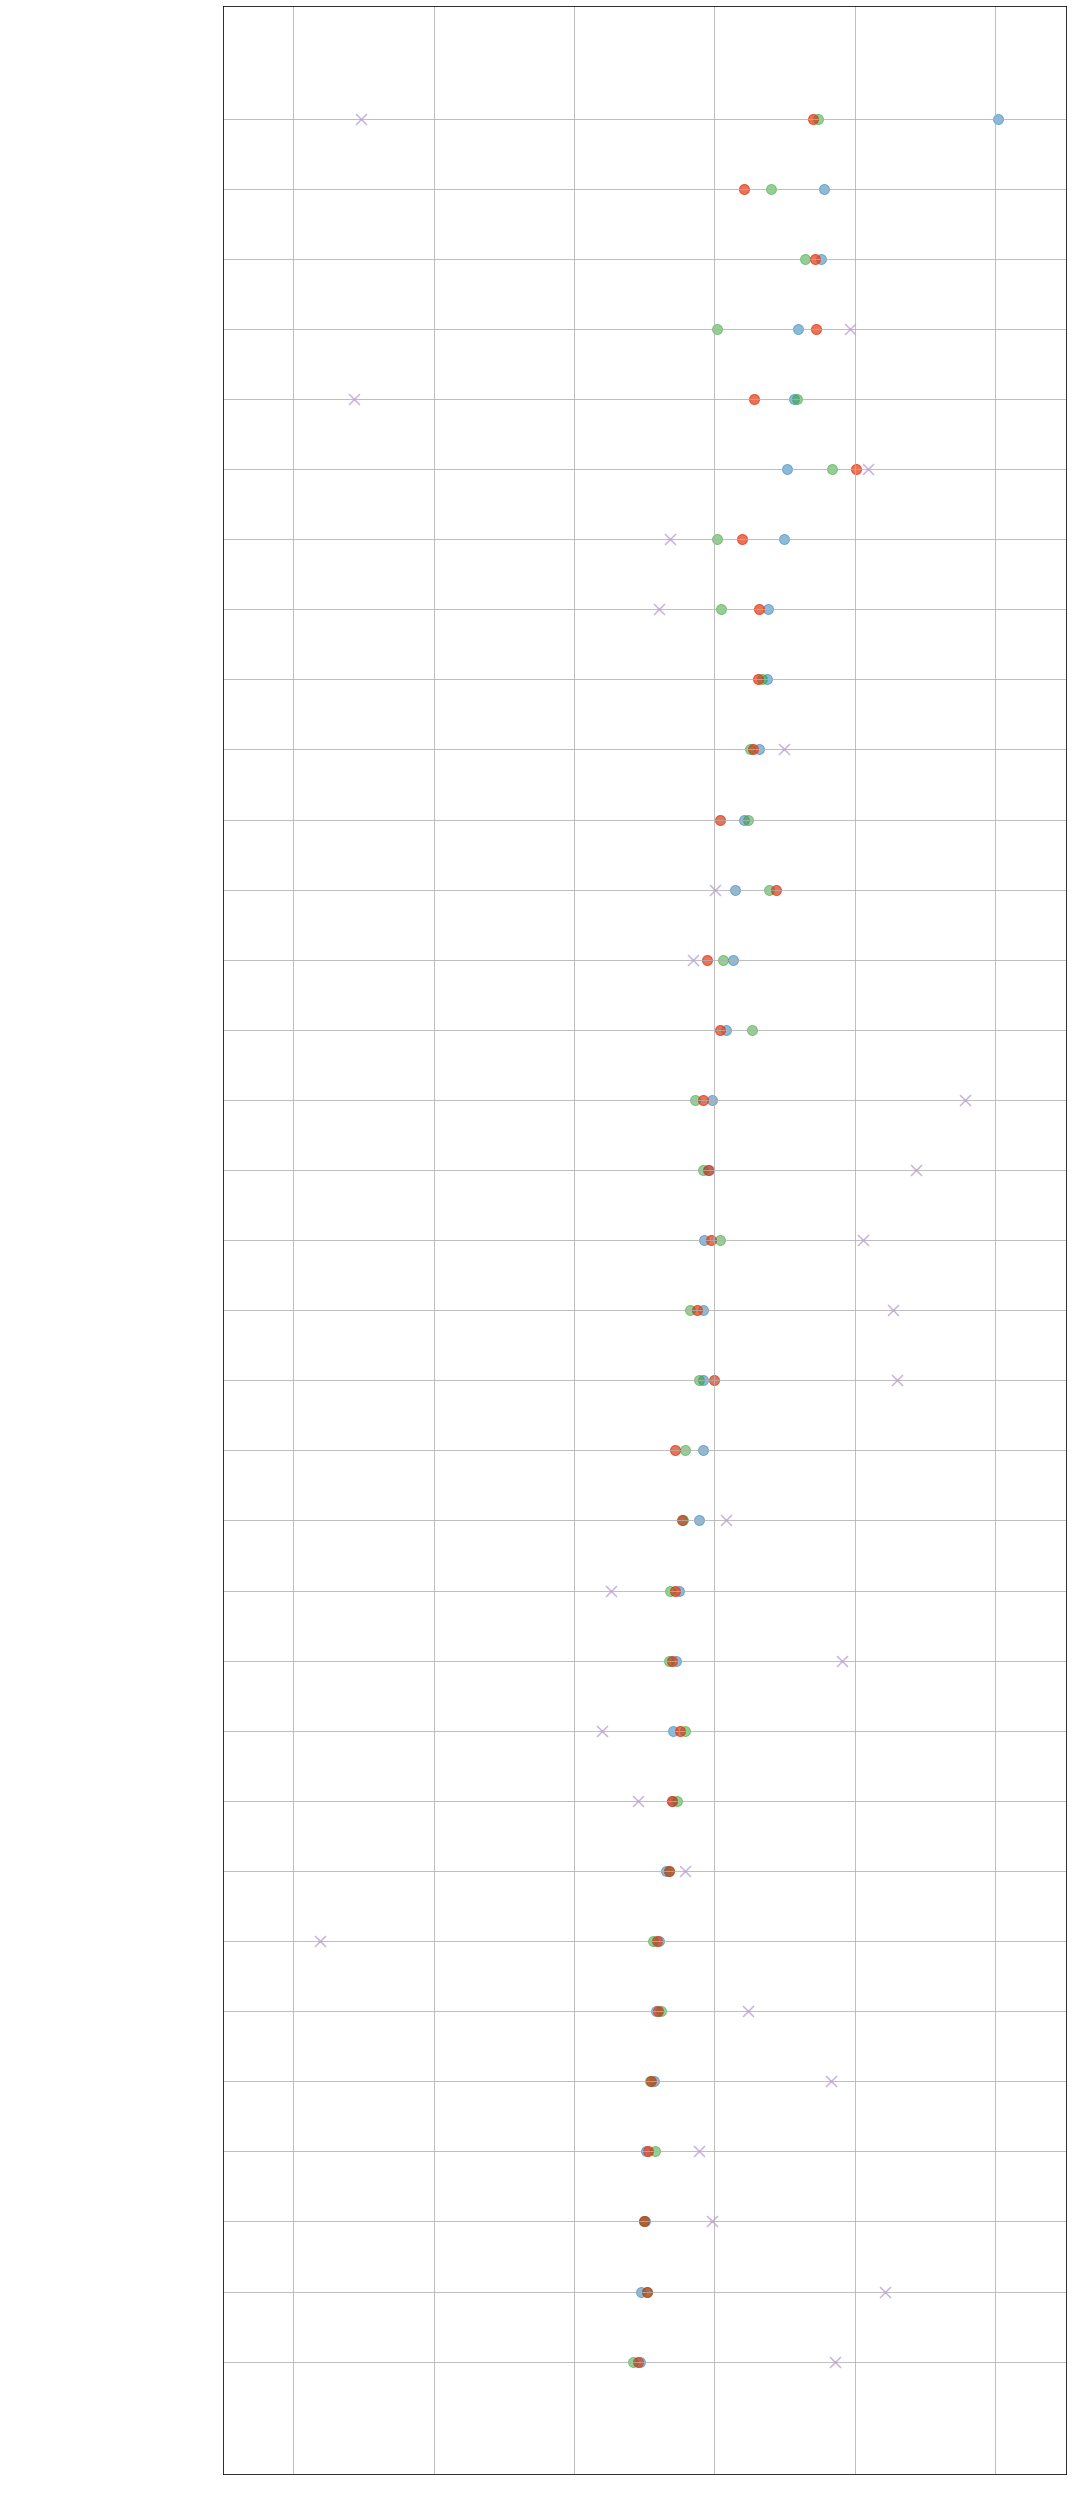

In [13]:
# # # # Added code 

#How do binders bind to WT RBD for all three replicates

aalpha_aff = aalpha_data_all['aalpha_pred_affinity_all_codons (nM)']

fig = plt.figure(figsize=(15,35))

x=np.arange(len(aalpha_aff))
y=aalpha_data_all['SARS-CoV2 WT affinty nM (1)'].sort_values()
plt.scatter(y,x,alpha=0.5, s =100)

x=np.arange(len(aalpha_aff))
y=aalpha_data_all['SARS-CoV2 WT affinty nM (2)'][y.index]
plt.scatter(y,x,alpha=0.5, s =100)

x=np.arange(len(aalpha_aff))
y=aalpha_data_all['SARS-CoV2 WT affinty nM (3)'][y.index]
plt.scatter(y,x,alpha=0.5, s =100)

x=np.arange(len(aalpha_aff))
y=aalpha_data_all['SARS-CoV2 WT affinty nM (2)'][y.index]
plt.scatter(y,x,alpha=0.5, s =100)

x=np.arange(len(aalpha_aff))
y=aalpha_data_all['affinity_RBD_nM_ln'][y.index]
plt.scatter(y,x,alpha=0.5, marker='x', s =120)

labels=list(aalpha_data_all['Name'][y.index])
plt.yticks(range(len(labels)), labels, size='medium')

plt.ylabel('Antibodies', c='white')
plt.xlabel('log KD (nM)', c='white')

plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.xlim(-5,7)
# plt.xlim(0,5)

plt.grid()
plt.tight_layout()

#plt.gca().invert_yaxis()

# Heatmap of statistically significant variants

FileNotFoundError: [Errno 2] No such file or directory: './figures/clinical_abs_heatmap.png'

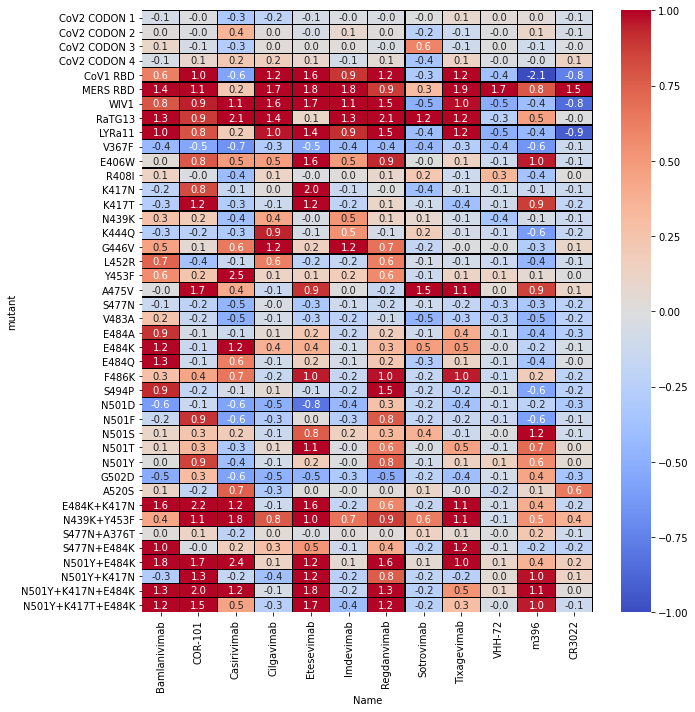

In [9]:
def heatmap1(dfphase,filepath,annotbool):
    #manually removed due to low expression / poor binding to ACE2
    dfphase=dfphase[~(dfphase.matalpha.str.contains("_A376T"))] 
    #manually removed CoV2 isogenic while keeping library COV2 WT
    dfphase=dfphase[~(dfphase.matalpha.str.contains("'SARS-CoV2_RBD'"))] 

    #Calculating p-value for all mutants based by comparing against WT replicates

    binderlist=[]
    mutantlist=[]
    plist=[]
    foldlist=[]

    for xbinder in range(0,len(dfphase.mata.unique())):
        dftemp=dfphase[dfphase.mata == dfphase.mata.unique()[xbinder]]
        dfwt=dftemp[dftemp.matalpha.str.contains('CODON')]
        wt_samples = list(dfwt[1].dropna()) + list(dfwt[2].dropna()) + list(dfwt[3].dropna()) 
        for xmut in range(0,len(dfphase.matalpha.unique())):
            dfmut=dftemp[dftemp.matalpha == dfphase.matalpha.unique()[xmut]]
            mut_samples = list(dfmut[1].dropna()) + list(dfmut[2].dropna()) + list(dfmut[3].dropna()) 
            [stat, p] = scipy.stats.mannwhitneyu(mut_samples, wt_samples)
            plist.append(p)
            foldlist.append(np.mean(mut_samples)-np.mean(wt_samples))
            binderlist.append(dfphase.mata.unique()[xbinder])
            mutantlist.append(dfphase.matalpha.unique()[xmut])

    pdf=pd.DataFrame({'mutant':mutantlist,'binder':binderlist,'p':plist,'fold':foldlist})

    pdf=pdf.merge(names4,left_on='binder',right_on='Short_Name')

    pdf.mutant= pdf.mutant.str.replace('SARS-', '')
    pdf.mutant= pdf.mutant.str.replace('CoV2 ', '')
    pdf.mutant= pdf.mutant.str.replace('WT CODON', 'CoV2 CODON')

    foldpivot=pdf.pivot(columns='Name',index='mutant',values='fold')

    ## Moving CR3022 to the back
    dftemp = foldpivot.pop('CR3022') # remove column b and store it in df1
    foldpivot['CR3022']=dftemp # add b series as a 'new' column.

    ##

    newindex=['CoV2 CODON 1',
     'CoV2 CODON 2',
     'CoV2 CODON 3',
     'CoV2 CODON 4',
     'CoV1 RBD',
     'MERS RBD',
     'WIV1',
     'RaTG13',
     'LYRa11',
     'V367F',
     'E406W', 
     'R408I',
     'K417N',
     'K417T',
     'N439K',
     'K444Q',
     'G446V',
     'L452R',
     'Y453F',
     'A475V', 
     'S477N',
     'V483A',
     'E484A',
     'E484K',
     'E484Q',
     'F486K',
     'S494P',
     'N501D',
     'N501F',
     'N501S',
     'N501T',
     'N501Y', 
     'G502D',
     'A520S',
     'E484K+K417N',
     'N439K+Y453F',
     'S477N+A376T',
     'S477N+E484K',
     'N501Y+E484K',
     'N501Y+K417N',
     'N501Y+K417N+E484K',
     'N501Y+K417T+E484K',]

    foldpivot=foldpivot.reindex(index = newindex)

    #Plotting heatmap

    import matplotlib
    matplotlib.rcParams.update({'font.size': 10})
    plt.figure(figsize=(10,10))
    sns.heatmap(foldpivot,cmap='coolwarm',annot=annotbool,
                vmin=-1,vmax=1,linewidth=.1,
                linecolor='black', fmt=".1f",cbar=True)
    plt.tight_layout()
    plt.savefig(filepath,dpi=300)
    plt.show()
    return(foldpivot)
    
    


#Plotting clinical antibodies heatmap 
a=df5[df5.binderno < 10]
c=df[df.mata.str.contains('ACE2')|
    (df.mata.str.contains('CoV_binder_29'))|
    (df.mata.str.contains('CoV_binder_24_LH'))|
    (df.mata.str.contains('CoV_binder_25_HL'))] #VHH72
dfphase=pd.concat([a,c]) 
heatmap1(dfphase,'./figures/clinical_abs_heatmap.png',annotbool=True)

#Plotting all antibodies heatmap 
a=df5
c=df[df.mata.str.contains('ACE2')|
    (df.mata.str.contains('CoV_binder_29'))|
    (df.mata.str.contains('CoV_binder_24_LH'))|
    (df.mata.str.contains('CoV_binder_25_HL'))] #VHH72
dfphase=pd.concat([a,c]) 
foldpivot=heatmap1(dfphase,'./figures/all_abs_heatmap.png',annotbool=False)

foldpivot.to_csv('Supplementary_Table9_CuratedFoldDiffAllAbs.csv')